# Torch Batteries Example: Function Fitting with MLP

This notebook demonstrates how to use the `torch-batteries` library to train a Multi-Layer Perceptron (MLP) for function fitting. We'll use the event-driven training approach with the `@charge` decorator to define training, validation, testing, and prediction steps.

## Overview

We'll be fitting a polynomial function: `y = (x-1)(x-6)(x-7)` using a neural network with the Battery trainer class.

## 1. Setup and Dependencies

First, let's import the required libraries and check the versions of torch-batteries and PyTorch.

In [1]:
# Import torch-batteries and other dependencies
import torch

import torch_batteries

print(f"torch-batteries version: {torch_batteries.__version__}")
print(f"PyTorch version: {torch.__version__}")

torch-batteries version: 0.2.0
PyTorch version: 2.9.1


## 2. Data Preparation

We'll create a synthetic dataset by sampling from the polynomial function `y = (x-1)(x-6)(x-7)` and split it into training, validation, and test sets.

In [2]:
# Prepare data loaders
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

x = np.linspace(0, 10, 300).reshape(-1, 1).astype(np.float32)
y = ((x - 1)*(x - 6)*(x - 7)).astype(np.float32)

x_tensor = torch.from_numpy(x)
y_tensor = torch.from_numpy(y)

BATCH_SIZE = 16

pred_full_dataset = TensorDataset(x_tensor, y_tensor)
pred_full_loader = DataLoader(pred_full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Split data into train/validation/test sets
x_train, x_rest, y_train, y_rest = train_test_split(
    x_tensor, y_tensor, test_size=0.3, random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rest, y_rest, test_size=0.5, random_state=42
)

# Create datasets and data loaders
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training samples: 210
Validation samples: 45
Test samples: 45
Batch size: 16
Training batches: 14
Validation batches: 3
Test batches: 3


## 3. Model Definition and Training

Now we'll define our MLP model using the `@charge` decorator to specify what happens during training, validation, testing, and prediction steps. This event-driven approach makes the code more organized and follows a clear pattern.

### Key Features:
- **@charge(Event.TRAIN_STEP)**: Defines the forward pass and loss calculation for training
- **@charge(Event.VALIDATION_STEP)**: Defines validation logic
- **@charge(Event.TEST_STEP)**: Defines testing logic
- **@charge(Event.PREDICT_STEP)**: Defines prediction logic (forward pass only)

In [3]:
# Import torch-batteries components
import torch.nn as nn
from torch.nn import functional as F
from torch_batteries import Battery, Event, charge

# Define MLP model with charge decorators
class MLPModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, output_dim=1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)
    
    @charge(Event.TRAIN_STEP)
    def training_step(self, batch):
        """Define what happens in each training step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        return loss
    
    @charge(Event.VALIDATION_STEP)
    def validation_step(self, batch):
        """Define what happens in each validation step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss
    
    @charge(Event.TEST_STEP)
    def test_step(self, batch):
        """Define what happens in each test step."""
        x, y = batch
        pred = self(x)
        loss = F.mse_loss(pred, y)
        
        return loss

    @charge(Event.PREDICT_STEP)
    def prediction_step(self, batch):
        """Define what happens during prediction."""
        x = batch[0]
        pred = self(x)
        return pred

model = MLPModel(input_dim=1, hidden_dim=64, output_dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

battery = Battery(model, optimizer=optimizer)

print("Starting training...")
train_results = battery.train(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=100
)

print("Training completed!")
print(f"Final Training Loss: {train_results['train_loss'][-1]:.6f}")
print(f"Final Validation Loss: {train_results['val_loss'][-1]:.6f}")

Starting training...
Epoch 1/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 879.7091
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 633.7908


Epoch 2/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 766.9500
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 527.4291


Epoch 3/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 579.2605
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 432.0099


Epoch 4/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 456.0501
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 441.3503


Epoch 5/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 442.5296
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 427.9805


Epoch 6/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 455.1464
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 423.7777


Epoch 7/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 435.7729
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 472.4847


Epoch 8/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 443.4366
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 431.6890


Epoch 9/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 432.4342
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 417.8665


Epoch 10/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 442.1446
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 414.4243


Epoch 11/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 424.8496
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 426.9117


Epoch 12/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 433.0202
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 423.9113


Epoch 13/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 426.1608
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 395.3306


Epoch 14/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 414.6883
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 393.5378


Epoch 15/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 407.6208
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 371.4315


Epoch 16/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 396.4695
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 347.7432


Epoch 17/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 383.3788
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 336.4814


Epoch 18/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 371.7954
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 321.6791


Epoch 19/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 366.6453
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 322.4181


Epoch 20/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 362.5293
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 317.9344


Epoch 21/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 367.1506
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 324.3576


Epoch 22/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 367.6050
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 330.5323


Epoch 23/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 358.1618
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 302.6862


Epoch 24/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 352.4597
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 318.6757


Epoch 25/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 365.8818
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 296.5613


Epoch 26/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 362.3797
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 330.2933


Epoch 27/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 350.8675
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 297.1714


Epoch 28/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 349.4501
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 292.5475


Epoch 29/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 331.2006
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 283.3723


Epoch 30/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 322.9581
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 283.5650


Epoch 31/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 312.6986
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 255.7215


Epoch 32/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 354.4516
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 309.0710


Epoch 33/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 312.4053
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 250.3176


Epoch 34/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 285.2014
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 252.2427


Epoch 35/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 302.6687
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 226.1423


Epoch 36/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 275.6293
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 253.6227


Epoch 37/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 269.2720
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 207.2543


Epoch 38/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 234.4857
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 200.1381


Epoch 39/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 221.0451
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 204.7777


Epoch 40/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 265.8557
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 179.3139


Epoch 41/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 214.8335
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 176.0277


Epoch 42/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 211.7531
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 160.4044


Epoch 43/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 203.7625
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 223.8458


Epoch 44/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 174.0738
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 143.8010


Epoch 45/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 184.6919
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 167.0103


Epoch 46/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 225.7730
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 153.4769


Epoch 47/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 142.8002
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 122.9549


Epoch 48/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 154.1357
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 162.0973


Epoch 49/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 147.6999
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 110.7138


Epoch 50/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 117.2246
Validation: 3/3 ███████████████████████████████████████ 100%, val_loss: 117.6360


Epoch 51/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 131.0678
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 91.8301


Epoch 52/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 100.4055
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 88.3539


Epoch 53/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 110.6368
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 86.2042


Epoch 54/100


Train: 14/14 ██████████████████████████████████████████████ 100%, loss: 100.5018
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 80.9714


Epoch 55/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 85.5316
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 68.8957


Epoch 56/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 79.2533
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 65.9390


Epoch 57/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 90.7670
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 62.2290


Epoch 58/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 81.1205
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 67.3486


Epoch 59/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 79.0159
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 58.0471


Epoch 60/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 63.4097
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 53.7144


Epoch 61/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 54.9435
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 48.6503


Epoch 62/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 59.0949
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 63.6010


Epoch 63/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 64.9217
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 42.3457


Epoch 64/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 48.7195
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 43.8640


Epoch 65/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 55.2490
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 36.9756


Epoch 66/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 43.2075
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 41.7287


Epoch 67/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 41.6009
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.8941


Epoch 68/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 60.6431
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.3370


Epoch 69/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 36.7081
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 30.6287


Epoch 70/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 32.2465
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 27.3536


Epoch 71/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 28.7974
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 28.6581


Epoch 72/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 27.3434
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.4561


Epoch 73/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 25.4615
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 25.6553


Epoch 74/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 30.6042
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 35.7604


Epoch 75/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 33.0413
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 38.8647


Epoch 76/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 58.8705
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 23.7222


Epoch 77/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 23.8488
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 20.2302


Epoch 78/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 23.3713
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 18.9616


Epoch 79/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 19.3836
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 24.5629


Epoch 80/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 20.2858
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.7003


Epoch 81/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 20.3262
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 39.6874


Epoch 82/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 26.5324
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 22.2039


Epoch 83/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 18.3765
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 23.8989


Epoch 84/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 24.2905
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.9058


Epoch 85/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 15.4494
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.1067


Epoch 86/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 14.8135
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 20.8590


Epoch 87/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 38.8273
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 27.8438


Epoch 88/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 44.7981
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 45.7614


Epoch 89/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 30.2244
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 36.8474


Epoch 90/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 62.0448
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 12.1751


Epoch 91/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 18.3131
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 15.8074


Epoch 92/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 14.6104
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.4978


Epoch 93/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.6513
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.0880


Epoch 94/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.7755
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 9.5378


Epoch 95/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 10.7990
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 8.1110


Epoch 96/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 11.5183
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 7.8171


Epoch 97/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 8.8380
Validation: 3/3 █████████████████████████████████████████ 100%, val_loss: 6.8149


Epoch 98/100


Train: 14/14 ████████████████████████████████████████████████ 100%, loss: 7.7091
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 12.8861


Epoch 99/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 11.4150
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 16.2421


Epoch 100/100


Train: 14/14 ███████████████████████████████████████████████ 100%, loss: 12.4877
Validation: 3/3 ████████████████████████████████████████ 100%, val_loss: 11.1403

Training completed!
Final Training Loss: 12.487685
Final Validation Loss: 11.140291


## 4. Model Evaluation

Let's evaluate our trained model on the test set to see how well it generalizes to unseen data.

In [4]:
test_results = battery.test(test_loader)
print(f"Final Test Loss: {test_results['test_loss']:.6f}")

Test: 3/3 ██████████████████████████████████████████████████ 100%, loss: 12.4698

Final Test Loss: 12.469788


## 5. Results Visualization

Finally, let's visualize the training progress and see how well our model learned to approximate the target function.

Predict: 19/19 ████████████████████████████████████████████████████████████ 100%


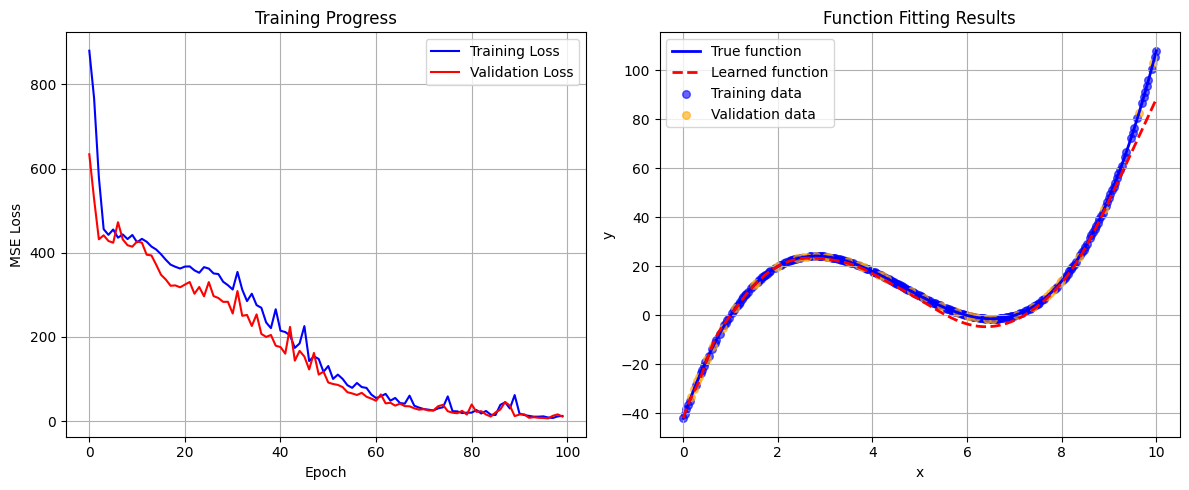

In [5]:
import matplotlib.pyplot as plt

# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results['train_loss'], 'b-', label='Training Loss')
plt.plot(train_results['val_loss'], 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

predictions = battery.predict(pred_full_loader)['predictions']

# Concatenate predictions
y_pred = torch.cat(predictions, dim=0).cpu().numpy()
x_np = x_tensor.cpu().numpy()

# Plot actual vs predicted function
plt.subplot(1, 2, 2)
plt.plot(x_np, y, 'b-', label='True function', linewidth=2)
plt.plot(x_np, y_pred, 'r--', label='Learned function', linewidth=2)
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, c='blue', label='Training data')
plt.scatter(x_val.numpy(), y_val.numpy(), alpha=0.6, s=30, c='orange', label='Validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Fitting Results')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()